# Download Dataset

In [ ]:
import gdown

In [ ]:
!mkdir ./dataset

In [ ]:
cd dataset

In [ ]:
# info
id1 = "1cqfcs-7XXhh_kqIUPEde-lY6I9COUsjC"
gdown.download(id=id1, quiet=False)

# Train-val zip
id2 = "1YWjUODQWwQ3_vKSytqVdF4recqBOEe72"
gdown.download(id=id2, quiet=False)

# test zip
id3 = "1diN3tNe2nR1eV3Px4gqlp6wp3XuLBwDy"
gdown.download(id=id3, quiet=False)

In [ ]:
# unzip dataset

from glob import glob
import zipfile

files = glob('*.zip')

for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('./')


In [ ]:
!rm -rf train_val.zip
!rm -rf TEST.zip

In [ ]:
cd ..

In [ ]:
# split random val and train
import os
import shutil
import random

# Define the path to the dataset
dataset_base_path = './dataset'
images_path = os.path.join(dataset_base_path, 'train_val/images')
masks_path = os.path.join(dataset_base_path, 'train_val/masks')

# Define the path for the train and val directories
train_images_path = os.path.join(dataset_base_path, 'train/images')
train_masks_path = os.path.join(dataset_base_path, 'train/masks')
val_images_path = os.path.join(dataset_base_path, 'val/images')
val_masks_path = os.path.join(dataset_base_path, 'val/masks')

# Create directories if they don't exist
for path in [train_images_path, train_masks_path, val_images_path, val_masks_path]:
    os.makedirs(path, exist_ok=True)

# Get the list of image files
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

# Shuffle and split the dataset
random.shuffle(image_files)
split_ratio = 0.9
split_index = int(len(image_files) * split_ratio)

train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move the files to the respective directories
for file in train_files:
    shutil.move(os.path.join(images_path, file), train_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), train_masks_path)

for file in val_files:
    shutil.move(os.path.join(images_path, file), val_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), val_masks_path)

# Ensure to replace 'path_to_your_dataset' with the actual path to your dataset.


# Import libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import random

import torchvision.transforms.functional as TF
import cv2

import torch.nn as nn
import torch.nn.functional as F


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None, augmentation_factor=10, apply_augmentation=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augmentation_factor = augmentation_factor
        self.apply_augmentation = apply_augmentation
        self.images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images) * self.augmentation_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.images)
        augment = idx >= len(self.images)

        image_path = os.path.join(self.images_dir, self.images[original_idx])
        mask_path = os.path.join(self.masks_dir, self.images[original_idx].replace('.jpg', '.bmp'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.apply_augmentation:
            image, mask = self.apply_transforms(image, mask)

        if self.transform is not None:
            image = self.transform(image)

        # Convert mask to class labels
        mask = self.convert_mask(mask)

        # Convert the NumPy array back to a PIL Image for target_transform
        mask = Image.fromarray(mask.astype(np.uint8))

        if self.target_transform is not None:
            mask = self.target_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.long)
        return image, mask


    def apply_transforms(self, image, mask):
        # Random horizontal flipping with 50% probability
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random rotation with 50% probability
        if random.random() > 0.5:
            angle = random.uniform(-20, 20)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, fill=0)

        # Random affine transformations (shear, zoom, width/height shift) with 50% probability
        if random.random() > 0.5:
            translate = (random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05))
            scale = random.uniform(1 - 0.05, 1 + 0.05)
            shear = random.uniform(-0.05, 0.05)
            image = TF.affine(image, angle=0, translate=translate, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=0, translate=translate, scale=scale, shear=shear, fill=0)

        return image, mask

    def convert_mask(self, mask):
        mapping = {
            (0, 0, 0): 0,
            (0, 0, 255): 1,
            (0, 255, 0): 2,
            (0, 255, 255): 3,
            (255, 0, 0): 4,
            (255, 0, 255): 5,
            (255, 255, 0): 6,
            (255, 255, 255): 7
        }
        mask = np.array(mask)
        class_map = np.zeros(mask.shape[:2], dtype=np.int32)
        for rgb, idx in mapping.items():
            class_map[(mask == rgb).all(axis=2)] = idx
        return class_map


In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((160, 160), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])

# Load the training dataset with augmentation
train_dataset = SegmentationDataset('dataset/train/images', 'dataset/train/masks',
                                   transform=transform, target_transform=target_transform,
                                   augmentation_factor=3, apply_augmentation=True)

# Load the validation dataset without augmentation
val_dataset = SegmentationDataset('dataset/val/images', 'dataset/val/masks',
                                  transform=transform, target_transform=target_transform,
                                  augmentation_factor=1, apply_augmentation=False)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)


/tmp/ipykernel_113061/2839208752.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((160, 160), interpolation=Image.NEAREST),


In [ ]:
for i , l in train_loader:
    print(i.shape)
    print(l.shape)
    break

torch.Size([32, 3, 160, 160])
torch.Size([32, 160, 160])


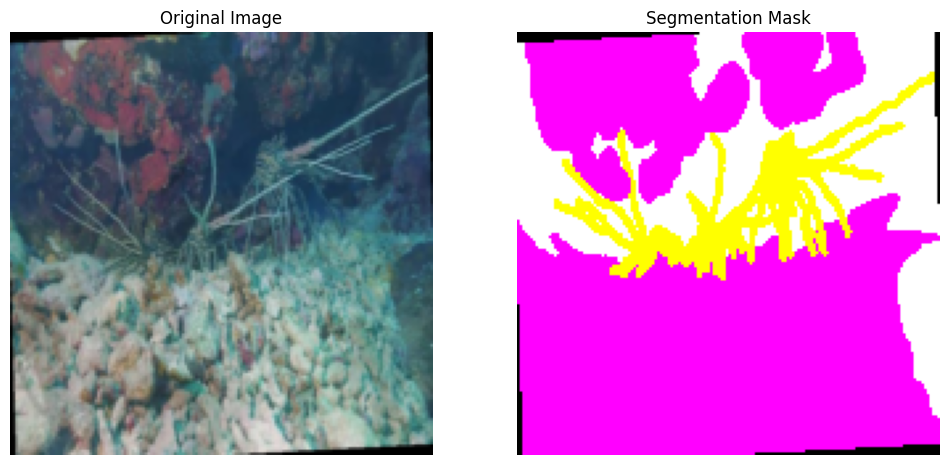

In [ ]:
# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background waterbody
        1: [0, 0, 255],    # Human divers
        2: [0, 255, 0],    # Plants/sea-grass
        3: [0, 255, 255],  # Wrecks/ruins
        4: [255, 0, 0],    # Robots/instruments
        5: [255, 0, 255],  # Reefs and invertebrates
        6: [255, 255, 0],  # Fish and vertebrates
        7: [255, 255, 255] # Sand/sea-floor (& rocks)
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image

# Get a random batch from the train_loader
images, masks = next(iter(train_loader))

# Choose a random image and mask from the batch
idx = random.randint(0, images.shape[0] - 1)
image = to_numpy(images[idx])
mask = to_numpy(masks[idx])

# Normalize image for visualization
image = np.transpose(image, (1, 2, 0))  # Change from CHW to HWC format
# Reversing the normalization
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

# Convert labels to RGB
mask_rgb = labels_to_rgb(mask)

# Plot the image and the mask separately
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)  # Display the mask separately
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

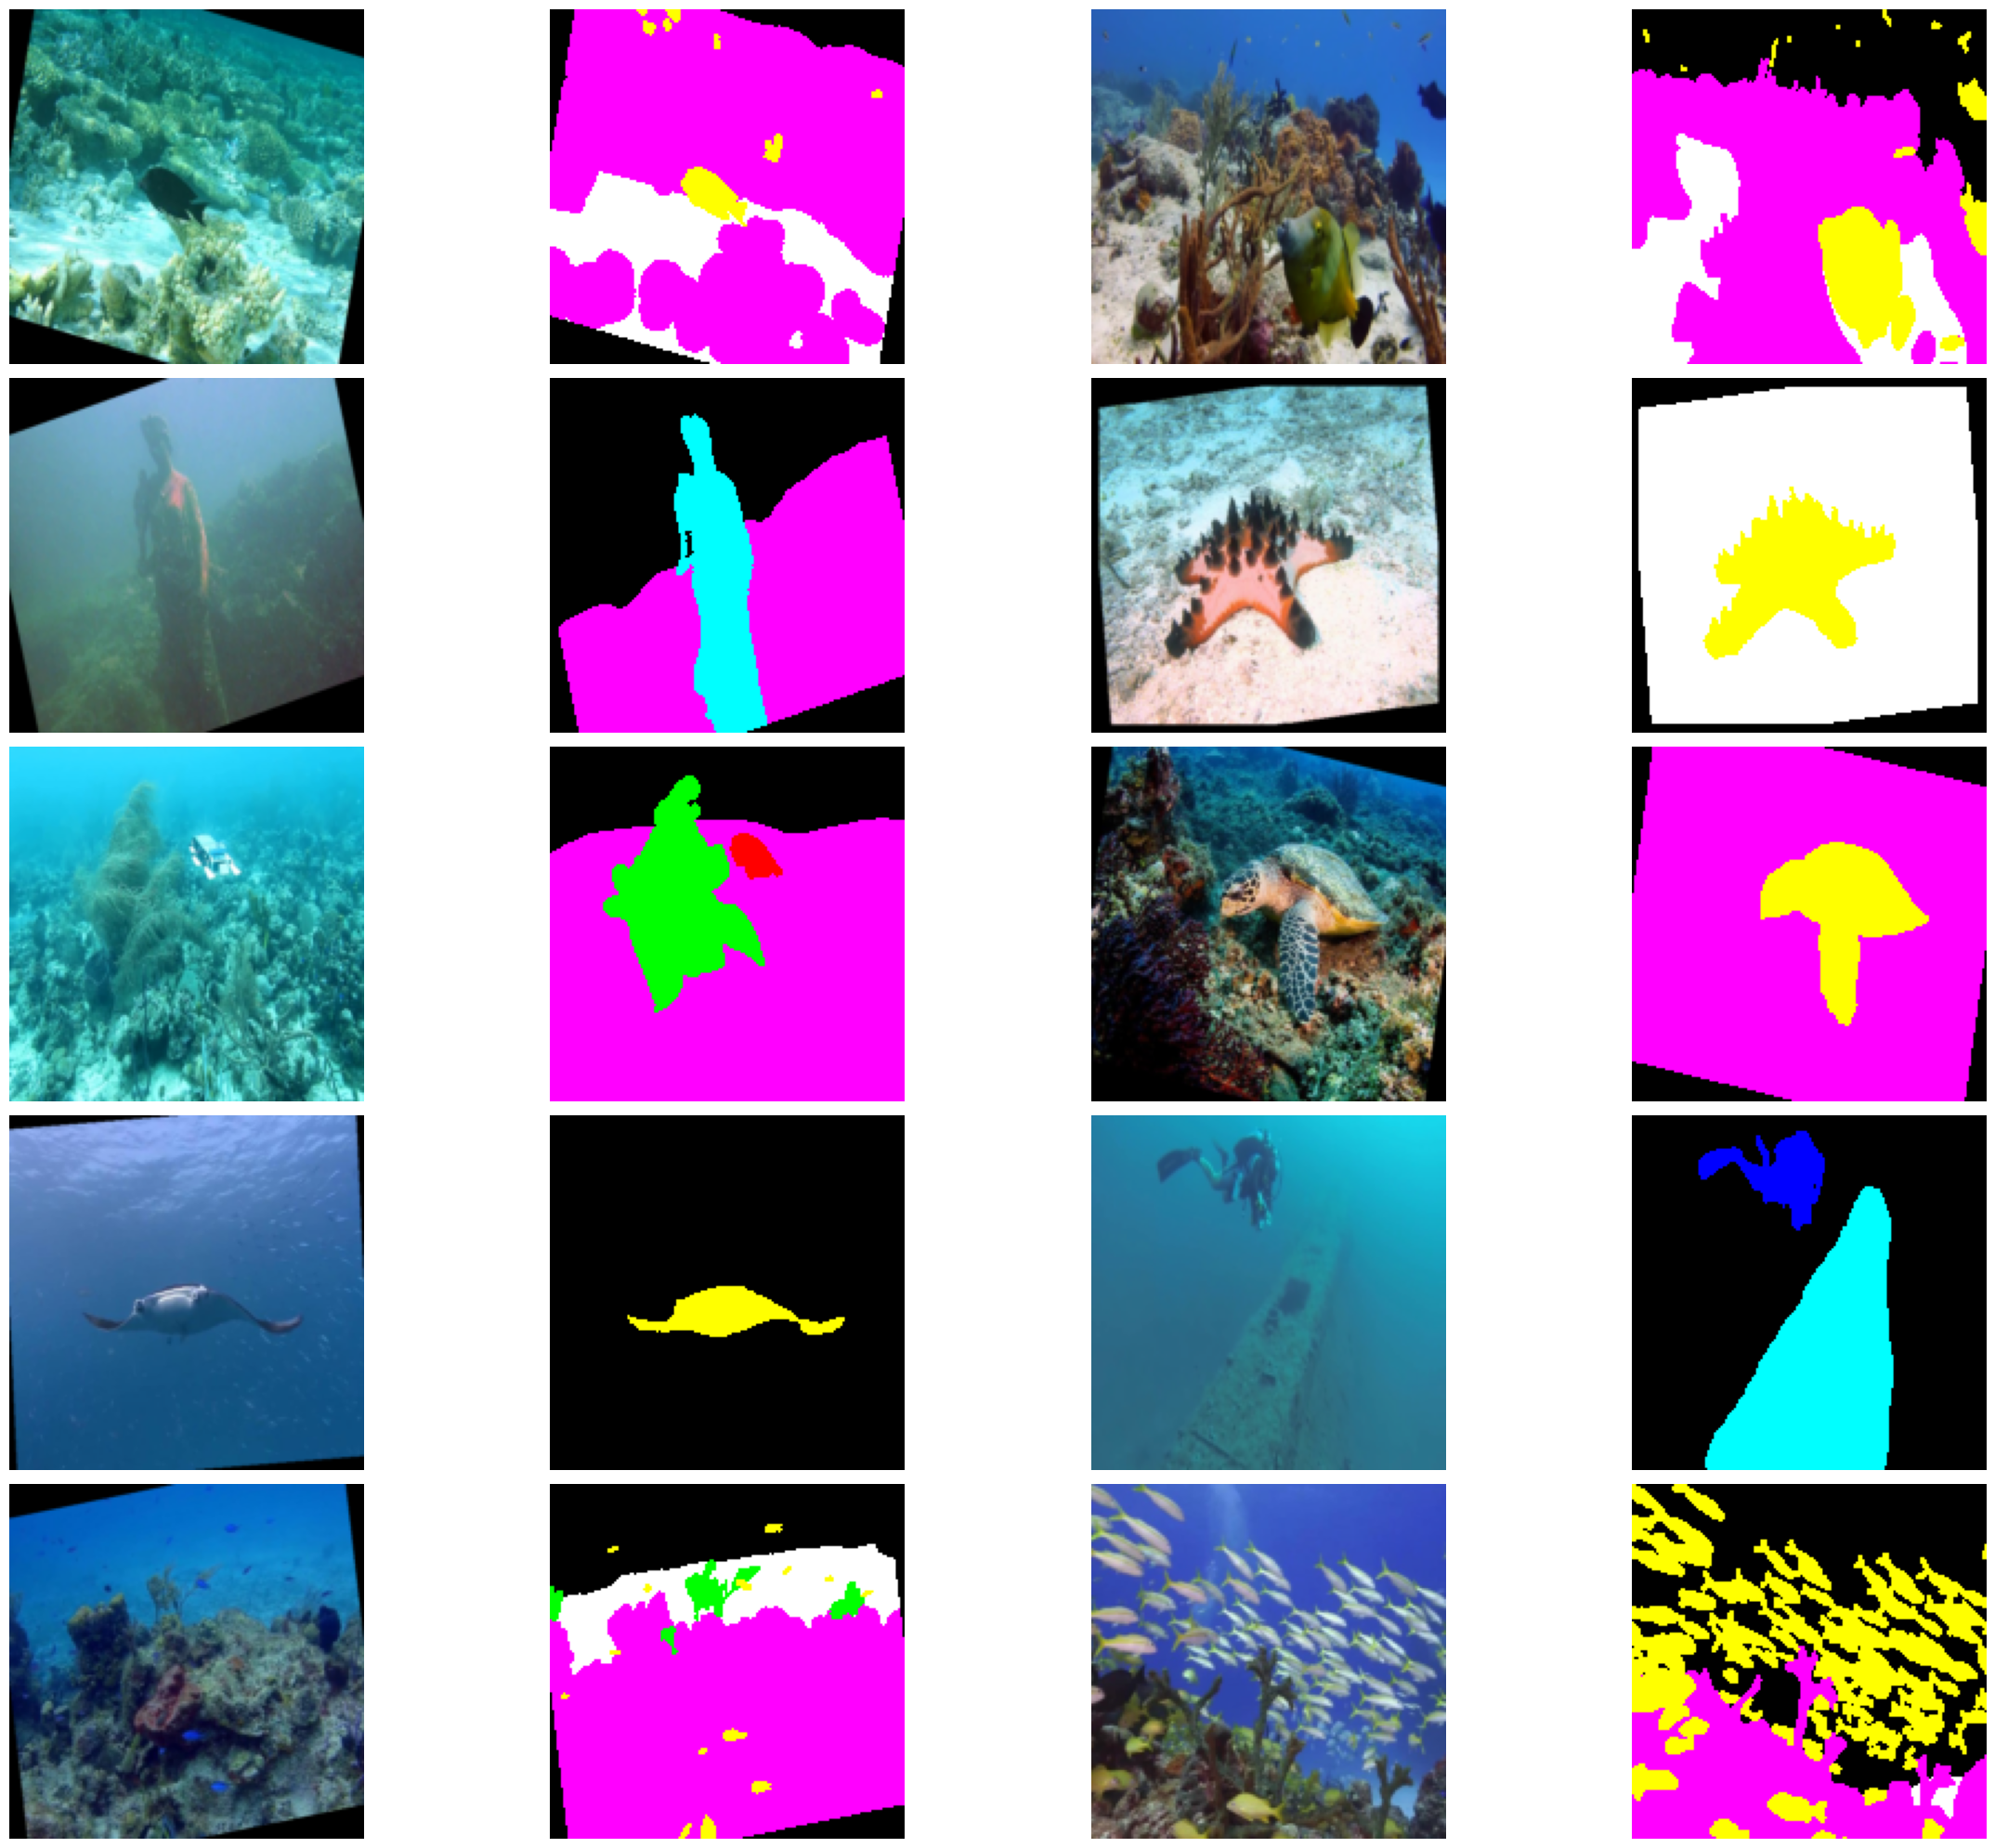

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'train_loader' is already defined and loaded with data
# Assuming the same structure for 'images' and 'masks' as in the previous code

# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background waterbody
        1: [0, 0, 255],    # Human divers
        2: [0, 255, 0],    # Plants/sea-grass
        3: [0, 255, 255],  # Wrecks/ruins
        4: [255, 0, 0],    # Robots/instruments
        5: [255, 0, 255],  # Reefs and invertebrates
        6: [255, 255, 0],  # Fish and vertebrates
        7: [255, 255, 255] # Sand/sea-floor (& rocks)
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image

# Get 10 random images and masks from the dataset
num_samples = 10
selected_images = []
selected_masks = []

for _ in range(num_samples):
    images, masks = next(iter(train_loader))
    idx = random.randint(0, images.shape[0] - 1)
    image = to_numpy(images[idx])
    mask = to_numpy(masks[idx])

    # Normalize and transpose image
    image = np.transpose(image, (1, 2, 0))  # Change from CHW to HWC format
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Convert labels to RGB
    mask_rgb = labels_to_rgb(mask)

    selected_images.append(image)
    selected_masks.append(mask_rgb)

# Plot the images and masks
plt.figure(figsize=(25, 20))  # Adjust the size of the figure

for i in range(num_samples):
    # Plot image
    plt.subplot(5, 4, 2*i + 1)
    plt.imshow(selected_images[i])
    plt.axis('off')

    # Plot mask
    plt.subplot(5, 4, 2*i + 2)
    plt.imshow(selected_masks[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Implement U-NET

In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.up1 = DoubleConv(512 + 256, 256)  # Adjusted channels for concatenation
        self.up2 = DoubleConv(256 + 128, 128)
        self.up3 = DoubleConv(128 + 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = F.max_pool2d(x1, 2)
        x3 = self.down1(x2)
        x4 = F.max_pool2d(x3, 2)
        x5 = self.down2(x4)
        x6 = F.max_pool2d(x5, 2)
        x7 = self.down3(x6)
        x8 = F.interpolate(x7, scale_factor=2, mode='bilinear', align_corners=True)
        x8 = torch.cat([x8, x5], dim=1)
        x9 = self.up1(x8)
        x10 = F.interpolate(x9, scale_factor=2, mode='bilinear', align_corners=True)
        x10 = torch.cat([x10, x3], dim=1)
        x11 = self.up2(x10)
        x12 = F.interpolate(x11, scale_factor=2, mode='bilinear', align_corners=True)
        x12 = torch.cat([x12, x1], dim=1)
        x13 = self.up3(x12)
        logits = self.outc(x13)
        return logits


In [ ]:
def calculate_miou(preds, labels, num_classes):
    iou_list = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Intersection
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # Union
        if union == 0:
            iou = float('nan')  # Avoid zero division
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the average IoU

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
n_channels = 3
n_classes = 8
lr = 0.0001
momentum = 0.5
n_epochs = 60

# Model, optimizer, and loss function
model = UNet(n_channels, n_classes).to(device)

# Create the Adam optimizer with momentum
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(momentum, 0.999))
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

criterion = nn.CrossEntropyLoss()

Using device: cuda:1


In [ ]:
from tqdm import tqdm
# Initialize the best validation mIoU
best_val_miou = 0.0


# Define the directory and filename for saving the model
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)
# Define the filename for saving the best model
best_model_filename = 'best_Unet.pth'

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_miou = []
val_miou = []

early_stop_patience = 8
early_stop_counter = 0

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_iou = 0.0

    for images, masks in tqdm(train_loader):
        # Move data to device
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_iou += calculate_miou(outputs, masks, n_classes)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_iou = total_train_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_miou.append(avg_train_iou)

    scheduler.step()

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            # Move data to device
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            total_val_iou += calculate_miou(outputs, masks, n_classes)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_miou.append(avg_val_iou)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Train mIoU: {avg_train_iou}, Val Loss: {avg_val_loss}, Val mIoU: {avg_val_iou}')

    # Check if the current validation mIoU is the best one
    if avg_val_iou > best_val_miou:
        print(f"New best validation mIoU: {avg_val_iou} at epoch {epoch+1}")
        best_val_miou = avg_val_iou

        # Save the model
        best_save_path = os.path.join(model_save_path, best_model_filename)
        torch.save(model.state_dict(), best_save_path)
        print(f"Best model saved to {best_save_path}")

        early_stop_counter = 0
    else:
        # Increment early stopping counter
        early_stop_counter += 1

    # Check if training should be stopped early
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation mIoU for {early_stop_patience} consecutive epochs.")
        break

100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 1, Train Loss: 1.4003568098957377, Train mIoU: 0.21506597022543805, Val Loss: 1.1935667991638184, Val mIoU: 0.2658091138111526
New best validation mIoU: 0.2658091138111526 at epoch 1
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:07<00:00,  2.76s/it]


Epoch 2, Train Loss: 1.1229313168310582, Train mIoU: 0.2673725204313152, Val Loss: 1.0125161290168763, Val mIoU: 0.26556745799175674


100%|██████████| 133/133 [06:02<00:00,  2.73s/it]


Epoch 3, Train Loss: 1.0032060222518175, Train mIoU: 0.29284682544294743, Val Loss: 0.9424321293830872, Val mIoU: 0.29483868905751415
New best validation mIoU: 0.29483868905751415 at epoch 3
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 4, Train Loss: 0.9236939755597509, Train mIoU: 0.3168473266460467, Val Loss: 0.8469906210899353, Val mIoU: 0.3257944623615774
New best validation mIoU: 0.3257944623615774 at epoch 4
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 5, Train Loss: 0.8704778717872792, Train mIoU: 0.33952353225593535, Val Loss: 0.857431173324585, Val mIoU: 0.3256102401558114


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 6, Train Loss: 0.828090562856287, Train mIoU: 0.3538738049898112, Val Loss: 0.8237179636955261, Val mIoU: 0.3381847138514832
New best validation mIoU: 0.3381847138514832 at epoch 6
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 7, Train Loss: 0.7822248102130747, Train mIoU: 0.3749641901798945, Val Loss: 0.7628097891807556, Val mIoU: 0.3326613240148574


100%|██████████| 133/133 [06:06<00:00,  2.75s/it]


Epoch 8, Train Loss: 0.7545525158258309, Train mIoU: 0.3865205808824101, Val Loss: 0.7368115067481995, Val mIoU: 0.3685061850163178
New best validation mIoU: 0.3685061850163178 at epoch 8
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:10<00:00,  2.78s/it]


Epoch 9, Train Loss: 0.7252888796024752, Train mIoU: 0.3992082480750691, Val Loss: 0.6896272659301758, Val mIoU: 0.3706225081737231
New best validation mIoU: 0.3706225081737231 at epoch 9
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:07<00:00,  2.76s/it]


Epoch 10, Train Loss: 0.6886554938509948, Train mIoU: 0.418751354770097, Val Loss: 0.7249373674392701, Val mIoU: 0.35967651086418984


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 11, Train Loss: 0.6740146418263141, Train mIoU: 0.428770523457339, Val Loss: 0.7080266833305359, Val mIoU: 0.39668085548482784
New best validation mIoU: 0.39668085548482784 at epoch 11
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:07<00:00,  2.77s/it]


Epoch 12, Train Loss: 0.6471468541855202, Train mIoU: 0.43964526551247396, Val Loss: 0.7251419425010681, Val mIoU: 0.36743070110665793


100%|██████████| 133/133 [06:09<00:00,  2.78s/it]


Epoch 13, Train Loss: 0.6286912338626116, Train mIoU: 0.45263047991394406, Val Loss: 0.6931400299072266, Val mIoU: 0.37250038460788215


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 14, Train Loss: 0.6092238520321093, Train mIoU: 0.47722950891877686, Val Loss: 0.7219527125358581, Val mIoU: 0.3908127520445498


100%|██████████| 133/133 [06:06<00:00,  2.76s/it]


Epoch 15, Train Loss: 0.5773551006962482, Train mIoU: 0.5079864595676464, Val Loss: 0.6544701814651489, Val mIoU: 0.4250708257093182
New best validation mIoU: 0.4250708257093182 at epoch 15
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:10<00:00,  2.78s/it]


Epoch 16, Train Loss: 0.5491554815518228, Train mIoU: 0.5300759559392063, Val Loss: 0.7846391320228576, Val mIoU: 0.36441731352304707


100%|██████████| 133/133 [06:04<00:00,  2.74s/it]


Epoch 17, Train Loss: 0.5298835632944465, Train mIoU: 0.5435596417810248, Val Loss: 0.6209438681602478, Val mIoU: 0.45408277297783767
New best validation mIoU: 0.45408277297783767 at epoch 17
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:06<00:00,  2.76s/it]


Epoch 18, Train Loss: 0.5141642344625372, Train mIoU: 0.5591569103813393, Val Loss: 0.6138377666473389, Val mIoU: 0.40945568662805015


100%|██████████| 133/133 [06:04<00:00,  2.74s/it]


Epoch 19, Train Loss: 0.49830082439838497, Train mIoU: 0.5657679271220335, Val Loss: 0.6895913004875183, Val mIoU: 0.39208772872754444


100%|██████████| 133/133 [06:06<00:00,  2.76s/it]


Epoch 20, Train Loss: 0.46938899742033247, Train mIoU: 0.5847304374891015, Val Loss: 0.643868911266327, Val mIoU: 0.44835683326168374


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 21, Train Loss: 0.45038400019021857, Train mIoU: 0.5984794269756978, Val Loss: 0.6051597356796264, Val mIoU: 0.4307374430877286


100%|██████████| 133/133 [06:06<00:00,  2.75s/it]


Epoch 22, Train Loss: 0.4371306808819448, Train mIoU: 0.612594030133054, Val Loss: 0.6146934628486633, Val mIoU: 0.4559916569170899
New best validation mIoU: 0.4559916569170899 at epoch 22
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 23, Train Loss: 0.41529370071296406, Train mIoU: 0.628251760981302, Val Loss: 0.637852668762207, Val mIoU: 0.41602157084393987


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 24, Train Loss: 0.40323774102038906, Train mIoU: 0.6350936005582324, Val Loss: 0.5839039444923401, Val mIoU: 0.4397182632587805


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 25, Train Loss: 0.37994436661999925, Train mIoU: 0.6510789084995237, Val Loss: 0.6013740181922913, Val mIoU: 0.4546669629970606


100%|██████████| 133/133 [06:06<00:00,  2.76s/it]


Epoch 26, Train Loss: 0.3619056442626437, Train mIoU: 0.6670039962823114, Val Loss: 0.5905352473258972, Val mIoU: 0.4691984883595592
New best validation mIoU: 0.4691984883595592 at epoch 26
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 27, Train Loss: 0.34976489360171154, Train mIoU: 0.6707398123754265, Val Loss: 0.5706908226013183, Val mIoU: 0.46186015513101186


100%|██████████| 133/133 [06:04<00:00,  2.74s/it]


Epoch 28, Train Loss: 0.3456993209464209, Train mIoU: 0.6791462118873014, Val Loss: 0.5556323826313019, Val mIoU: 0.49269298240815707
New best validation mIoU: 0.49269298240815707 at epoch 28
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:07<00:00,  2.76s/it]


Epoch 29, Train Loss: 0.3263253034057474, Train mIoU: 0.6868033610918323, Val Loss: 0.5785656213760376, Val mIoU: 0.5004216220691534
New best validation mIoU: 0.5004216220691534 at epoch 29
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:06<00:00,  2.75s/it]


Epoch 30, Train Loss: 0.31261323795730905, Train mIoU: 0.6968361622518068, Val Loss: 0.5754592537879943, Val mIoU: 0.46970181897298396


100%|██████████| 133/133 [06:09<00:00,  2.78s/it]


Epoch 31, Train Loss: 0.3096832826845628, Train mIoU: 0.7007128808513907, Val Loss: 0.6150513648986816, Val mIoU: 0.4432569591654426


100%|██████████| 133/133 [06:07<00:00,  2.76s/it]


Epoch 32, Train Loss: 0.2927803189906859, Train mIoU: 0.7110750067867044, Val Loss: 0.5936800837516785, Val mIoU: 0.4670381179584989


100%|██████████| 133/133 [06:08<00:00,  2.77s/it]


Epoch 33, Train Loss: 0.2830629348754883, Train mIoU: 0.7269633634209643, Val Loss: 0.5933914184570312, Val mIoU: 0.48820609122872527


100%|██████████| 133/133 [06:09<00:00,  2.78s/it]


Epoch 34, Train Loss: 0.2676792715052913, Train mIoU: 0.7348826254148476, Val Loss: 0.5855369210243225, Val mIoU: 0.480110329000488


100%|██████████| 133/133 [06:07<00:00,  2.76s/it]


Epoch 35, Train Loss: 0.26738263162455167, Train mIoU: 0.7309675253416235, Val Loss: 0.6776091694831848, Val mIoU: 0.45119147215935235


100%|██████████| 133/133 [06:03<00:00,  2.74s/it]


Epoch 36, Train Loss: 0.2563249580842212, Train mIoU: 0.737983061158158, Val Loss: 0.5879766523838044, Val mIoU: 0.49445335276409813


100%|██████████| 133/133 [06:13<00:00,  2.81s/it]


Epoch 37, Train Loss: 0.24885720787639903, Train mIoU: 0.736912691734421, Val Loss: 0.600075876712799, Val mIoU: 0.468886389251551
Early stopping at epoch 37 due to no improvement in validation mIoU for 8 consecutive epochs.


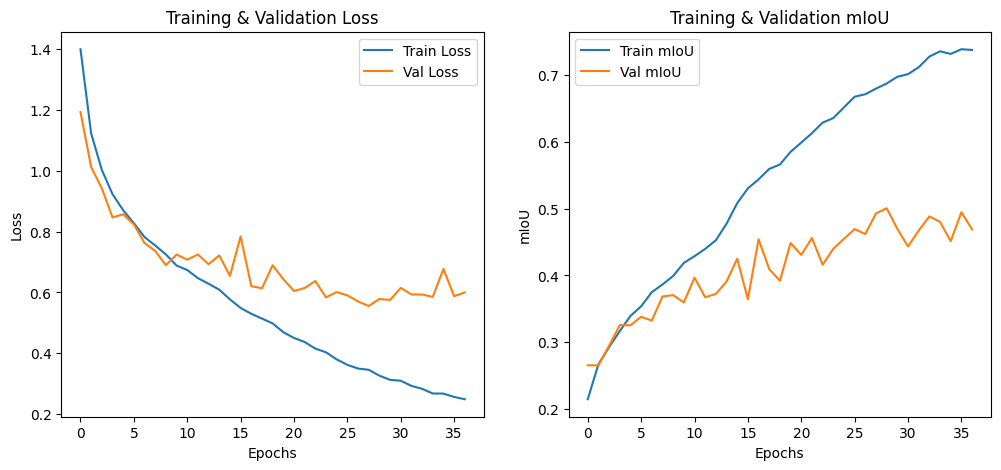

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation mIoU
plt.subplot(1, 2, 2)
plt.plot(train_miou, label='Train mIoU')
plt.plot(val_miou, label='Val mIoU')
plt.title('Training & Validation mIoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()

plt.show()

# Test Model

In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((160, 160), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])


# Load the validation dataset without augmentation
test_dataset = SegmentationDataset('dataset/TEST/images', 'dataset/TEST/masks',
                                  transform=transform, target_transform=target_transform,
                                  augmentation_factor=1, apply_augmentation=False)


# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

/tmp/ipykernel_157358/1183833253.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((160, 160), interpolation=Image.NEAREST),


In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
n_channels = 3
n_classes = 8

# Model, optimizer, and loss function
model = UNet(n_channels, n_classes).to(device)

Using device: cuda:1


In [ ]:
# Define the path to the saved model
saved_model_path = 'models/best_Unet_FINAL.pth'

# Make sure the model is in evaluation mode
model.load_state_dict(torch.load(saved_model_path))
model.eval()
print("Model loaded")

Model loaded


In [ ]:
total_test_iou = 0.0

# Run the model on the test data
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        total_test_iou += calculate_miou(outputs, masks, n_classes)

avg_test_iou = total_test_iou / len(test_loader)
print(f'Test mIoU: {avg_test_iou}')

Test mIoU: 0.4735920496486267


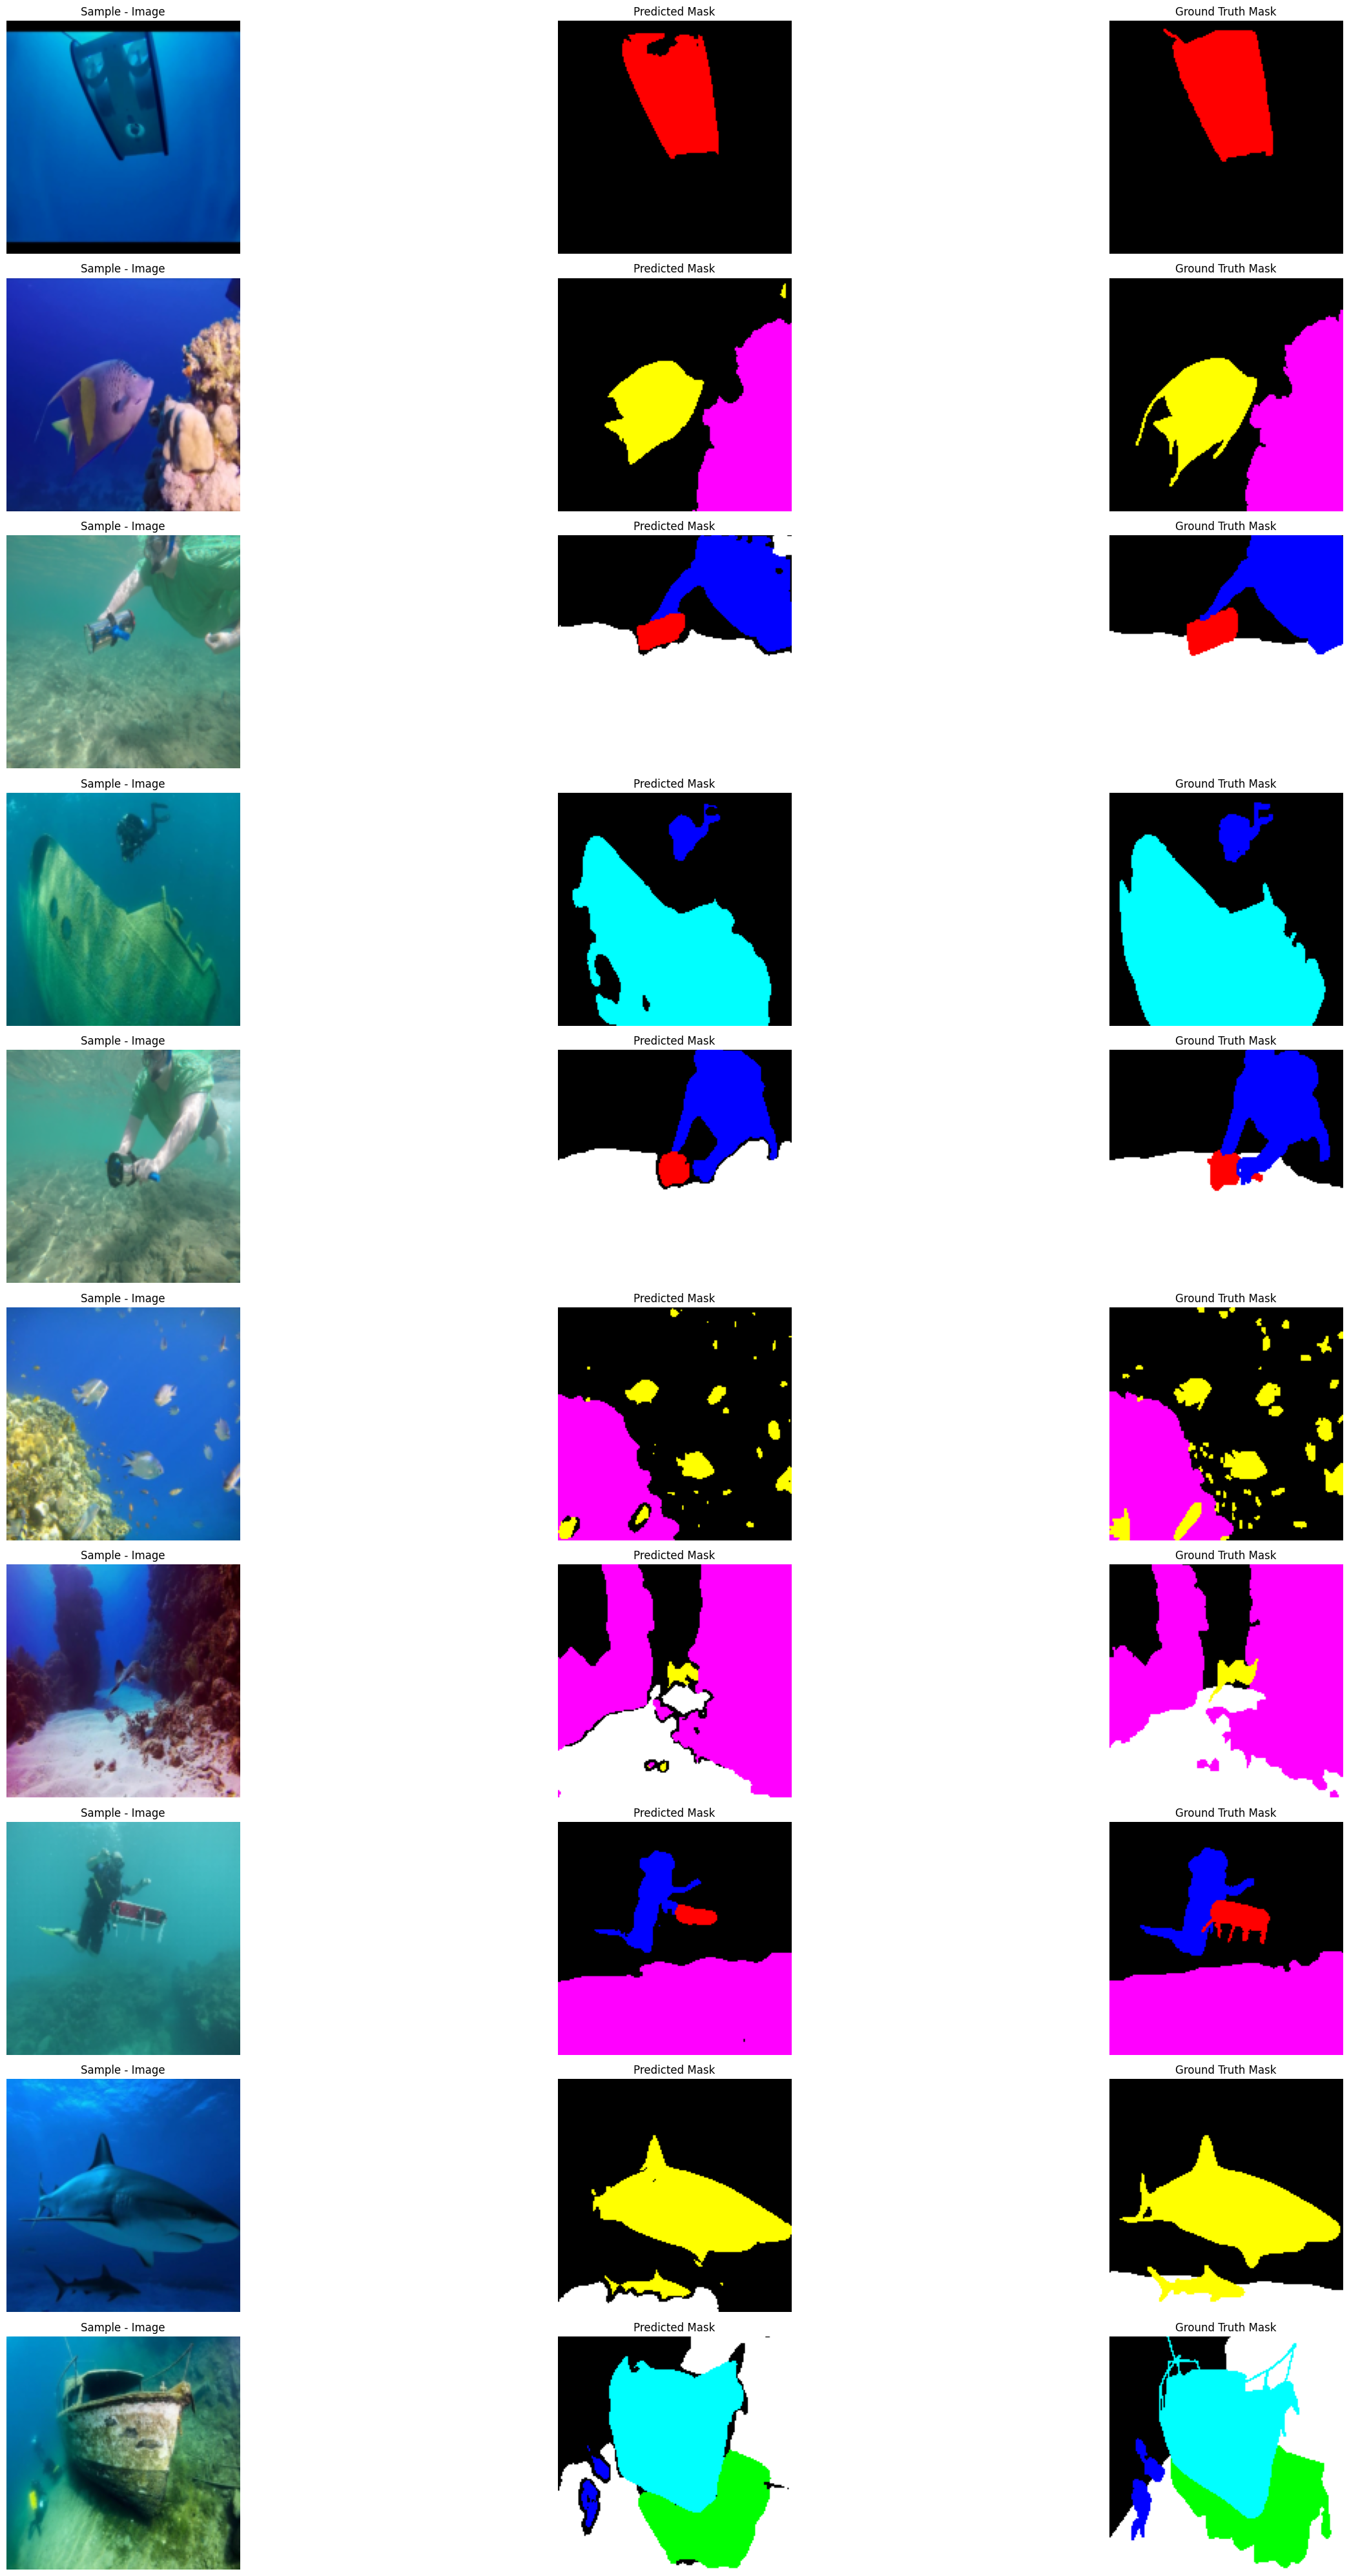

In [ ]:
# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()
# Function to get predictions from the model
def get_predictions(model, loader):
    images, _ = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        preds = model(images)
    return images, preds

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background
        1: [0, 0, 255],    # Class 1
        2: [0, 255, 0],    # Class 2
        3: [0, 255, 255],  # Class 3
        4: [255, 0, 0],    # Class 4
        5: [255, 0, 255],  # Class 5
        6: [255, 255, 0],  # Class 6
        7: [255, 255, 255] # Class 7
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image


# Function to calculate mIoU for each sample
def calculate_sample_miou(preds, gts, n_classes):
    sample_miou = []
    for pred, gt in zip(preds, gts):
        miou = calculate_miou(pred.unsqueeze(0), gt.unsqueeze(0), n_classes)
        sample_miou.append(miou.item())
    return sample_miou


# Modified function to get predictions and ground truth masks
def get_predictions_and_gt(model, loader):
    model.eval()
    all_images, all_preds, all_gts = [], [], []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            all_images.append(images)
            all_preds.append(preds)
            all_gts.append(masks)
    return all_images, all_preds, all_gts

# Get predictions and ground truth masks
all_images, all_preds, all_gts = get_predictions_and_gt(model, test_loader)

# Flatten the lists
images_flat = torch.cat(all_images)
preds_flat = torch.cat(all_preds)
gts_flat = torch.cat(all_gts)

# Calculate mIoU for each sample
sample_miou = calculate_sample_miou(preds_flat, gts_flat, n_classes)

# Create a list of tuples (miou, image, prediction, ground_truth)
samples_with_miou = list(zip(sample_miou, images_flat, preds_flat, gts_flat))
top_samples = sorted(samples_with_miou, key=lambda x: x[0], reverse=True)[:10]

# Plot the top 10 samples
plt.figure(figsize=(30, 40))
for i, (miou, image, pred, gt) in enumerate(top_samples):
    image = to_numpy(image)
    pred = to_numpy(torch.argmax(pred, dim=0))
    gt = to_numpy(gt.squeeze(0))

    # Normalize and clip image for visualization
    image = np.transpose(image, (1, 2, 0))
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Convert predicted and ground truth labels to RGB
    pred_rgb = labels_to_rgb(pred)
    gt_rgb = labels_to_rgb(gt)

    # Plotting
    plt.subplot(10, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f'Sample - Image')
    plt.axis('off')

    plt.subplot(10, 3, 3*i + 2)
    plt.imshow(pred_rgb)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(10, 3, 3*i + 3)
    plt.imshow(gt_rgb)
    plt.title('Ground Truth Mask')
    plt.axis('off')

plt.tight_layout()
plt.savefig("10_samples_iou.png")
plt.show()